In [43]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=2000, weights=[0.1, 0.9])
y

array([1, 1, 1, ..., 1, 1, 1])

In [88]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

pred = cross_val_predict(RidgeClassifier(class_weight={0: 2, 1: 1}), X, y)
print(classification_report(pred, y))

              precision    recall  f1-score   support

           0       0.46      0.78      0.58       124
           1       0.98      0.94      0.96      1876

    accuracy                           0.93      2000
   macro avg       0.72      0.86      0.77      2000
weighted avg       0.95      0.93      0.94      2000



In [71]:
data = []
weight = np.linspace(1, 15, 20)
for i in weight:
    pred = cross_val_predict(RidgeClassifier(class_weight={0: i, 1:1}), X, y)
    data.append(classification_report(pred, y, output_dict=True))

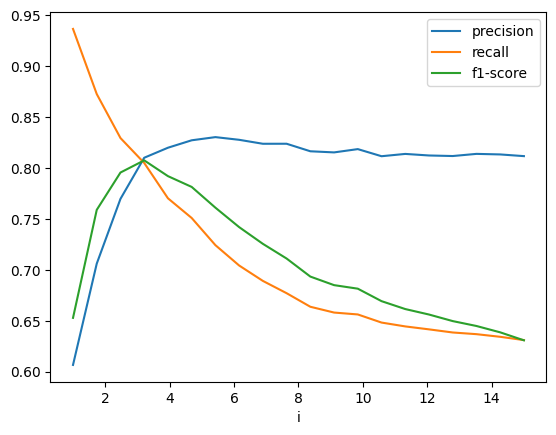

In [73]:
import pandas as pd

(pd.DataFrame([{**d['macro avg'], 'i': weight[i]} for i, d in enumerate(data)])
 .drop(columns=['support'])
 .plot(x='i'));

In [85]:
from sklearn.linear_model import LogisticRegression

data = []
probas = cross_val_predict(
    LogisticRegression(class_weight="balanced"), 
    X, 
    y, 
    method="predict_proba"
)
thresholds = np.linspace(0.1, 0.9, 100)

for threshold in thresholds:
    pred = probas[:, 1] >= threshold
    data.append(classification_report(pred, y, output_dict=True))    

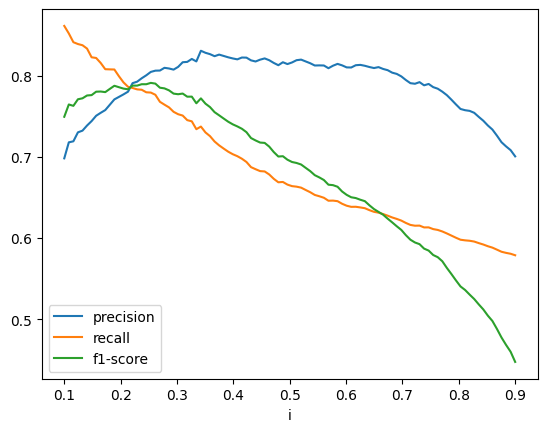

In [86]:
import pandas as pd

(pd.DataFrame([{**d['macro avg'], 'i': thresholds[i]} for i, d in enumerate(data)])
 .drop(columns=['support'])
 .plot(x='i'));

<br><br><br><br><br><br><br><br><br>

In [4]:
from drawdata import ScatterWidget

widget = ScatterWidget()
widget

ScatterWidget()

In [6]:
X, y = widget.data_as_X_y

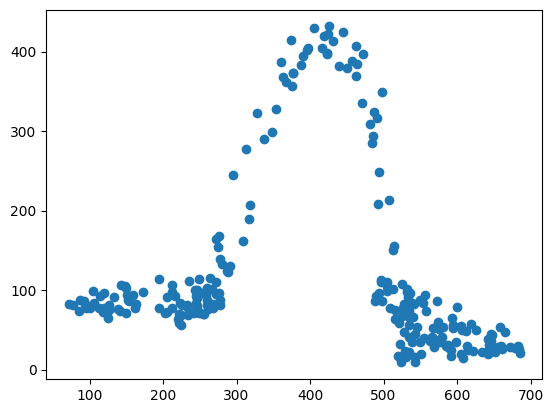

In [7]:
import matplotlib.pylab as plt

plt.scatter(X[:, 0], y)

In [11]:
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(SplineTransformer(n_knots=14, knots='quantile'), Ridge())
pipe.fit(X, y)

Pipeline(steps=[('splinetransformer',
                 SplineTransformer(knots='quantile', n_knots=14)),
                ('ridge', Ridge())])

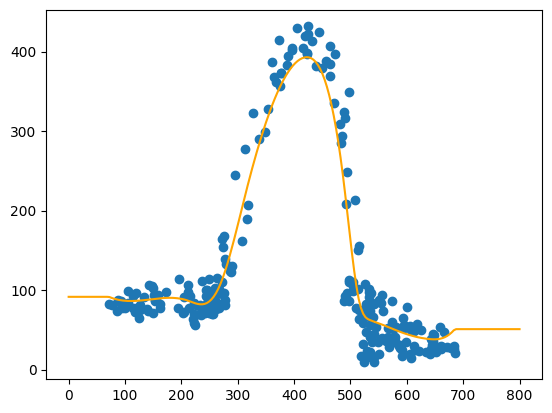

In [12]:
import numpy as np 

plt.scatter(X[:, 0], y)
xs = np.linspace(0, 800, 200)
plt.plot(xs, pipe.predict(xs.reshape(-1, 1)), color='orange')

But what if some datapoints are more important than others?

In [16]:
# Declare a pipelinef
pipe = make_pipeline(SplineTransformer(n_knots=14, knots='quantile'), Ridge())

# Not making use of the sample weight
pipe.fit(X, y)

# Making use of the sample weight in the 'ridge' component
pipe.fit(X, y, ridge__sample_weight=y)

Pipeline(steps=[('splinetransformer',
                 SplineTransformer(knots='quantile', n_knots=14)),
                ('ridge', Ridge())])

Recently scikit-learn has added some extra features to make this easier by the way!

In [20]:
import sklearn 
sklearn.set_config(enable_metadata_routing=True)

ridge = Ridge().set_fit_request(sample_weight=True)
spline = SplineTransformer(n_knots=14, knots='quantile').set_fit_request(sample_weight=False)

pipe = make_pipeline(spline, ridge)
pipe.fit(X, y, sample_weight=y)

Pipeline(steps=[('splinetransformer',
                 SplineTransformer(knots='quantile', n_knots=14)),
                ('ridge', Ridge())])

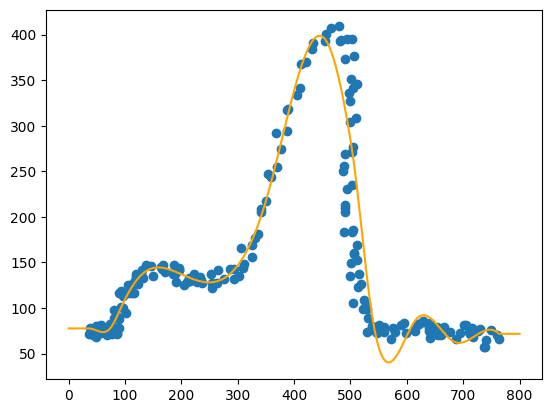

In [37]:
plt.scatter(X[:, 0], y)
plt.plot(xs, pipe.predict(xs.reshape(-1, 1)), color='orange')

There are some other use-cases for these sample weights that are worth diving into though.

- timeseries
- fairness

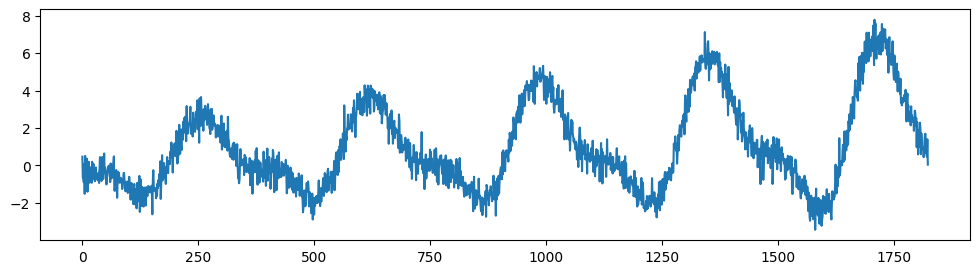

In [93]:
from sklego.datasets import make_simpleseries
import pandas as pd


yt = make_simpleseries(seed=1)
df = (pd.DataFrame({"yt": yt,
                   "date": pd.date_range("2000-01-01", periods=len(yt))})
      .assign(m=lambda d: d.date.dt.month, doy=lambda d: d.date.dt.dayofyear)
      .reset_index())



plt.figure(figsize=(12, 3))
plt.plot(make_simpleseries(seed=1));

In [94]:
df.head()

,index,yt,date,m,doy
0,0,0.468623,2000-01-01,1,1
1,1,-0.653622,2000-01-02,1,2
2,2,-0.615641,2000-01-03,1,3
3,3,-0.891481,2000-01-04,1,4
4,4,0.074618,2000-01-05,1,5


In [109]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import Ridge
from sklego.meta import DecayEstimator
from skrub import SelectCols
import numpy as np

pipe = make_pipeline(
    SelectCols('doy'),
    SplineTransformer(knots="quantile", extrapolation="periodic", n_knots=24),
    Ridge()
)

decayed = make_pipeline(
    SelectCols('doy'),
    SplineTransformer(knots="quantile", extrapolation="periodic", n_knots=24),
    DecayEstimator(Ridge(), decay_rate=0.99)
)


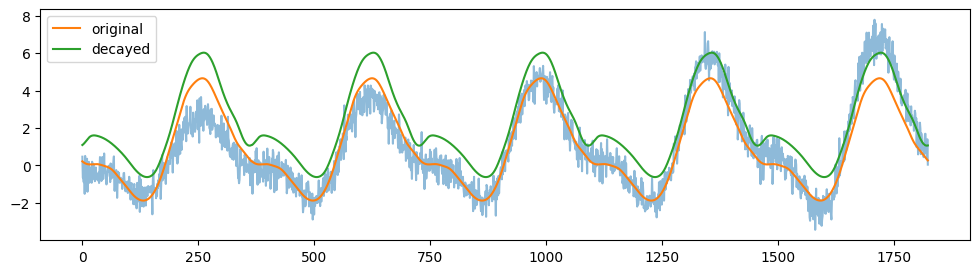

In [110]:
plt.figure(figsize=(12, 3))
plt.plot(df["yt"], alpha=0.5);
plt.plot(pipe.fit(df, df["yt"]).predict(df), label="original")
plt.plot(decayed.fit(df, df["yt"]).predict(df), label="decayed")
plt.legend();

In [3]:
from skrub import TableVectorizer
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd

In [4]:
df = pd.read_csv('data/car_prices.csv').dropna().head(10000)
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [5]:
cols = [c for c in df.columns if c not in ['sellingprice', 'mmr', 'salesdate', 'vin']]

In [154]:
from sklearn.model_selection import train_test_split

pipe = make_pipeline(TableVectorizer(), HistGradientBoostingRegressor())
X, y = df[cols], df['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [155]:
%%time

pipe.fit(X_train, y_train)

CPU times: user 12.2 s, sys: 3.37 s, total: 15.5 s
Wall time: 5.47 s


Pipeline(steps=[('tablevectorizer', TableVectorizer()),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor())])

In [156]:
colref = 'make'

In [157]:
X_test.assign(err = np.abs(pipe.predict(X_test) - y_test)).groupby([colref])['err'].mean()

/Users/vincent/Development/calmcode.io/venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vincent/Development/calmcode.io/venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vincent/Development/calmcode.io/venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


make
Acura             2302.136896
Audi              6671.550538
BMW               2224.165912
Bentley          22991.906207
Buick             2210.011655
Cadillac          2614.202324
Chevrolet         1924.756478
Chrysler          1202.684771
Dodge             1378.602958
FIAT              4882.052352
Ford              2047.604543
GMC               2820.523893
HUMMER            6954.002108
Honda             1438.799961
Hyundai           1711.100250
Infiniti          1698.905778
Jaguar            6483.770012
Jeep              2152.635703
Kia               1174.786385
Land Rover        4515.141347
Lexus             2290.491159
Lincoln           3627.698055
MINI              2053.475782
Maserati          6462.284131
Mazda             1372.635202
Mercedes-Benz     2794.032666
Mercury           8518.562592
Mitsubishi        1887.979447
Nissan            1354.885232
Oldsmobile        4979.354091
Pontiac           1888.926060
Porsche           8289.470257
Ram               3057.195655
Rolls

In [126]:
X_train.assign(weights=lambda d: 1 + (d[colref] == 'Kia')).head(3)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saledate,weights
1357,2012,Jaguar,XK,XKR,Convertible,automatic,ca,42.0,16234.0,silver,black,jpmorgan chase bank n.a.,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),1
397,2013,Kia,Sorento,SX,SUV,automatic,ca,47.0,20209.0,burgundy,black,high bid trading co inc,Wed Dec 17 2014 12:15:00 GMT-0800 (PST),2
2217,2014,Dodge,Grand Caravan,SXT,Minivan,automatic,ca,4.0,24052.0,—,black,enterprise holdings/gdp,Tue Dec 30 2014 12:30:00 GMT-0800 (PST),1


After toying around and setting the volkswagen weight to 10 ... we see something interesting.

In [176]:
weights = X_train.assign(weights=lambda d: 1 + 10 * (d[colref] == 'Volkswagen'))['weights']

In [177]:
weights.mean()

1.0592

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import sklearn 

sklearn.set_config(enable_metadata_routing=True)

ridge = Ridge().set_fit_request(sample_weight=True)

pipe = make_pipeline(TableVectorizer(), ridge)
X, y = df[cols], df['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
pipe.fit(X_train, y_train, sample_weights=weights)

In [178]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [179]:
%%time 

newpipe = make_pipeline(TableVectorizer(), HistGradientBoostingRegressor())
newpipe.fit(X_train, y_train, histgradientboostingregressor__sample_weight=weights);

CPU times: user 12.1 s, sys: 3.24 s, total: 15.4 s
Wall time: 5.37 s


In [180]:
# X_test.assign(err = np.abs(newpipe.predict(X_test) - y_test)).groupby([colref])['err'].mean()

In [181]:
X_train_small = X_train.loc[lambda d: d['make'] == 'Volkswagen']
y_train_subset = y_train[X_train_small.index]

smallpipe = make_pipeline(TableVectorizer(), HistGradientBoostingRegressor())
smallpipe.fit(X_train, y_train);

In [182]:
X_test_small = X_test.loc[lambda d: d['make'] == 'Volkswagen']
y_test_subset = y_test[X_test_small.index]

np.abs(smallpipe.predict(X_test_small) - y_test_subset).mean()

1353.118095246813

In [183]:
X_test.assign(err = np.abs(newpipe.predict(X_test) - y_test)).groupby([colref])['err'].mean().to_dict()['Volkswagen']

/Users/vincent/Development/calmcode.io/venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vincent/Development/calmcode.io/venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vincent/Development/calmcode.io/venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


1216.2163186962705